# Predict Nominated Movies: Oscar Prize Analysis

<img src="http://dl9fvu4r30qs1.cloudfront.net/4b/cf/f2190bd844da9eebb7436d49dd69/oscar-best-picture.jpg">

## Motivation:
As movie lovers, we watch a lot of movies every year. Sometimes we wonder, what is the standard of a good movie? In our understanding, those big movie producers in Hollywood have two general directions when making a film. Either a film can be a commercial success, or it can be an artistic success. As data scientists, we will try to help them determine whether a film can success artistically by predicting its chance of getting an Oscar nominee. 

## Background:
We found a dataset with all the Oscar nominated movies from 2006 to 2016. And a dataset with all popular movies in the past 100 years. 
We only focus on the important awards, which are best motion picture, best actor in a leading role, best actress in a leading role, best director and best writing (includes original screen play and adaptive screen play). Since they are usually highly related with the rating of a movie. A movie with high rating means it’s overall good. And all these five factors are essential to a movie as a whole.
The reason we don’t consider other awards is because there is a chance a regular movie wins a technical award like visual effect or music, or one character in that movie has a best supporting award due to his or her own acting. If we take these awards into account, it would lower the accuracy of the model.



## Problem:
1. Can we use IMDB Rating, Metascore, Box office to predict Oscar Nomination in the future?
2. Is our self-designed model performs well to predict the Oscar Nomination?

## 1. Data Collection 

Import the packages and libraries we will use 

pandas: used for genrating dataframes and tidying dataset
matplotlib: contains useful tools to do data analysis and realize data visualization
numpy: for array manipulation 
re: regular expression library, used for string splitting, matching, etc.
sklearn: contains useful tools for machine learning in Python

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import math
from sklearn import linear_model
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.preprocessing import PolynomialFeatures

Tidy the dataset which contains all the information of movies from 2006 to 2016. 
1. add 'Nomination' columns.
2. drop irrelevant columns such as 'Runtime', 'Actors', etc.
3. drop year 2016 which will not be used
4. print the head of the table

In [2]:
#input our data
data = pd.read_csv('IMDB-Movie-Data.csv')
#add nomination column to keep track of how many nominees a movie gets
data['Nomination'] = 0
#drop unused columns
data = data.drop(['Runtime (Minutes)', 'Actors', 'Director', 'Description', 'Rank'], axis = 1)
#since we will exam the nominations from 2006 to 2015, so we drop the rows where year = 2016
data = data[data.Year != 2016]
data = data.reset_index()
data = data.drop(['index'], axis = 1)
data.head()

,Title,Genre,Year,Rating,Votes,Revenue (Millions),Metascore,Nomination
0,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",2014,8.1,757074,333.13,76.0,0
1,Prometheus,"Adventure,Mystery,Sci-Fi",2012,7.0,485820,126.46,65.0,0
2,Bahubali: The Beginning,"Action,Adventure,Drama",2015,8.3,76193,6.50,NaN,0
3,Interstellar,"Adventure,Drama,Sci-Fi",2014,8.6,1047747,187.99,74.0,0
4,5- 25- 77,"Comedy,Drama",2007,7.1,241,NaN,NaN,0


This is another dataset we will use which contains information about nominated movies from 1900s to 2015
1. read the data from the excel 
2. find the row that starts at year 2006, and cut the table to only contains data from 2006 to 2015
3. reset the index of the table 
4. print the table head

In [3]:
awards = pd.read_csv('database.csv')

#get the row number which start from year 2006
index = 0
for i, row in awards.iterrows():
    if row['Year'] == '2006':
        index = i
        break

#change the dataframe to include data from 2006-2015
awards = awards[index:]
awards = awards.reset_index()
awards = awards.drop(['index'], axis = 1)
awards.head()

,Year,Ceremony,Award,Winner,Name,Film
0,2006,79,Actor in a Leading Role,NaN,Leonardo DiCaprio,Blood Diamond
1,2006,79,Actor in a Leading Role,NaN,Ryan Gosling,Half Nelson
2,2006,79,Actor in a Leading Role,NaN,Peter O'Toole,Venus
3,2006,79,Actor in a Leading Role,NaN,Will Smith,The Pursuit of Happyness
4,2006,79,Actor in a Leading Role,1.0,Forest Whitaker,The Last King of Scotland


## 2. Data Tidying

Search through the second table and add those nominated movies to the first table in column 'nomination'
1. iterate over the first table for each movie Mi, if Mi is contained in the table2, then update the 'nomination' column
2. since there are various names for nominations, I use regex to find the first five most important ones.

In [4]:
for i, rowi in data.iterrows():
    name = rowi['Title']
    
    for j, rowj in awards.iterrows():
        if rowj['Film'] == name:
            
            # in order to make our prediction more precise, we will only take "more valueble" nominations into account
            # so we will take "writing, actor, actress, directing, best movie" this five categories
            
            if (re.match("Writing.*", rowj['Award']) or re.match("Actor (in a Leading Role)",rowj['Award']) 
                or re.match("Actress (in a Leading Role)",rowj['Award']) or rowj['Award'] == 'Directing' 
                or rowj['Award'] == 'Best Picture'):
                
                #increment the number of nominations
                cur = rowi['Nomination'] + 1
                data.set_value(i, 'Nomination', cur)
                

rename the "Revenue (Millions)" to Revenue and print the information of the table

In [5]:
data = data.rename(index = str, columns = {'Revenue (Millions)':'Revenue'})
data.count()

Title         703
Genre         703
Year          703
Rating        703
Votes         703
Revenue       667
Metascore     668
Nomination    703
dtype: int64

There are many movies do not have the information of Revenue and Metascore.
1. For the lost data, we fill the nil with 0.
2. Then remove rows whose Revenue and Metascore is 0

In [6]:
data = data.fillna(0)
data = data[data.Revenue != 0.0]
data = data[data.Metascore != 0.0]
data.count()

Title         640
Genre         640
Year          640
Rating        640
Votes         640
Revenue       640
Metascore     640
Nomination    640
dtype: int64

Generate the subtable that contains data with nomination greater than 0

In [7]:
nominate = data[data.Nomination > 0]
nominate.head()

,Title,Genre,Year,Rating,Votes,Revenue,Metascore,Nomination
18,The Wolf of Wall Street,"Biography,Comedy,Crime",2013,8.2,865134,116.87,75.0,1
19,Gone Girl,"Crime,Drama,Mystery",2014,8.1,636243,167.74,79.0,1
25,The Help,Drama,2011,8.1,342429,169.71,62.0,1
30,The Martian,"Adventure,Drama,Sci-Fi",2015,8.0,556097,228.43,80.0,1
33,12 Years a Slave,"Biography,Drama,History",2013,8.1,486338,56.67,96.0,1


## 3. Data  Visualization and Data Exploratory Analysis

### I. Nominated vs Overall by Rating, Revenue, Metascore, Votes

1. Generate the average Revenue, Rating, Votes, Meatscore for 'Nomination' table and overall table
2. plot the bar graph for each pair of table 

Conclusion: It's clear to see that 'Nominated Movie' has a slightly higher average revenue and rating score than the overall dataset. And 'Nominated Movie' has a much higher average Metascore and Votes than the overall dataset.

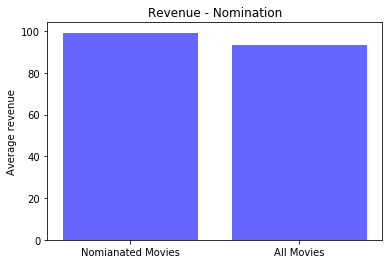

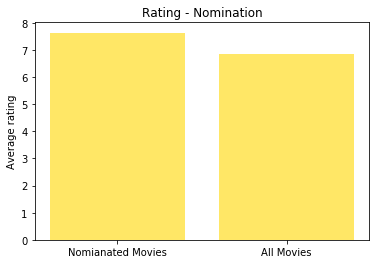

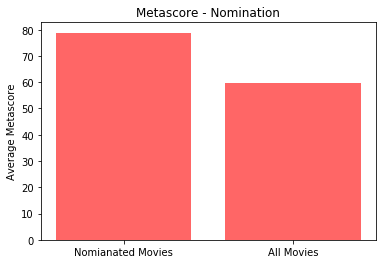

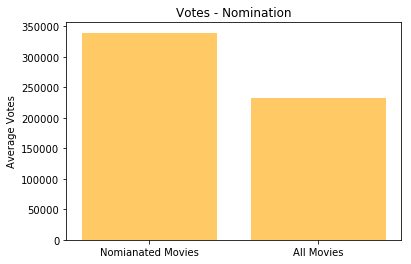

In [8]:
#calculate the mean of Revenue
ave1 = nominate['Revenue'].mean()
ave2 = data['Revenue'].mean()

#calculate the mean of Rating
ave3 = nominate['Rating'].mean()
ave4 = data['Rating'].mean()

#calculate the mean of Metascore
ave5 = nominate['Metascore'].mean()
ave6 = data['Metascore'].mean()

#calculate the mean of Votes
ave7 = nominate['Votes'].mean()
ave8 = data['Votes'].mean()

#store them in pairs in an array
array = [[ave1, ave2],[ave3, ave4], [ave5, ave6],[ave7, ave8]]
colors = ['blue','gold', 'red', 'orange']

#generate four bar graphs
for i in range(0,4):
    #x and y
    Objects = ('Nomianated Movies', "All Movies")
    y_pos = np.arange(len(Objects))
    plt.bar(y_pos, array[i], alpha=0.6, color = colors[i])
    plt.xticks(y_pos, Objects)
    if i == 0:
        plt.ylabel('Average revenue')
        plt.title('Revenue - Nomination')
    if i == 1:
        plt.ylabel('Average rating')
        plt.title('Rating - Nomination')
    if i == 2:
        plt.ylabel('Average Metascore')
        plt.title('Metascore - Nomination')
    if i == 3:
        plt.ylabel('Average Votes')
        plt.title('Votes - Nomination')
    plt.show()
plt.show()

### II. Rating distribution in different Genres by Violin plot 

Generate tables to draw violin plot to analyze the Rating distribution
1. drop irrelevant columns
2. reset indexs

In [9]:
data2 = data.drop(['Year','Votes','Revenue'], axis = 1)
data2 = data2.reset_index()
data2 = data2.drop(['index'], axis = 1)
data2.head()

,Title,Genre,Rating,Metascore,Nomination
0,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",8.1,76.0,0
1,Prometheus,"Adventure,Mystery,Sci-Fi",7.0,65.0,0
2,Interstellar,"Adventure,Drama,Sci-Fi",8.6,74.0,0
3,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",6.7,45.0,0
4,Star Wars: Episode VII - The Force Awakens,"Action,Adventure,Fantasy",8.1,81.0,0


The column Genre's categories are ambigious since one movie has many genres. So we split one row into multiple rows and count each movie exactly the number of genres. For example, the movie 'Prometheus' has three categories: adventure, mystery, sci-fi. Then I convert this row into three rows, each row has only one genre and append them into the table.
1. initialize a new array called data3, store all the new generated rows in the array 
2. concatenate these rows of array and generate a new dataframe 'data3'

In [10]:
data3 = []
cnt = 0
cnt2 = 0
#iterate through the data2 table and split the rows
for i, rowi in data2.iterrows():
    cate = re.split(',', rowi['Genre'])
    length = len(cate)
    cnt2 = cnt2 + 1
    for j in range(0, length):
        row = {'Title':[rowi['Title']], 'Genre':cate[j],'Rating':rowi['Rating'],'Metascore':rowi['Metascore'], 'Nomination':rowi['Nomination']}
        row = pd.DataFrame(data=row)
        data3.append(row)
        cnt = cnt + 1
        
#concatenate these rows
data3 = pd.concat(data3)
data3 = data3.reset_index()
data3.head()

,index,Genre,Metascore,Nomination,Rating,Title
0,0,Action,76.0,0,8.1,Guardians of the Galaxy
1,0,Adventure,76.0,0,8.1,Guardians of the Galaxy
2,0,Sci-Fi,76.0,0,8.1,Guardians of the Galaxy
3,0,Adventure,65.0,0,7.0,Prometheus
4,0,Mystery,65.0,0,7.0,Prometheus


Draw a violin graph to visualize the distribution of Rating for different genres
1. import the seaborn package which contains many useful plotting functions
2. generate the graph: 'genre' as the x-axis and 'rating' as the y-axis

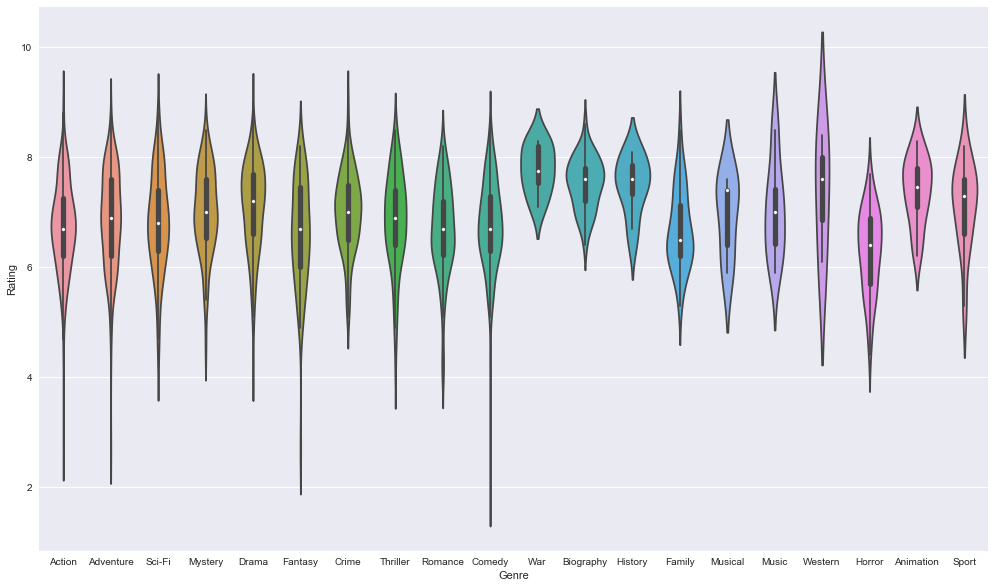

In [11]:
import seaborn as sns
import matplotlib as mpl

#adjust the figure size 
a4_dims = (17, 10)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.violinplot(x="Genre", y="Rating", data=data3)
sns.plt.show()

Draw a violin graph to visualize the distribution of Metascore for different genres

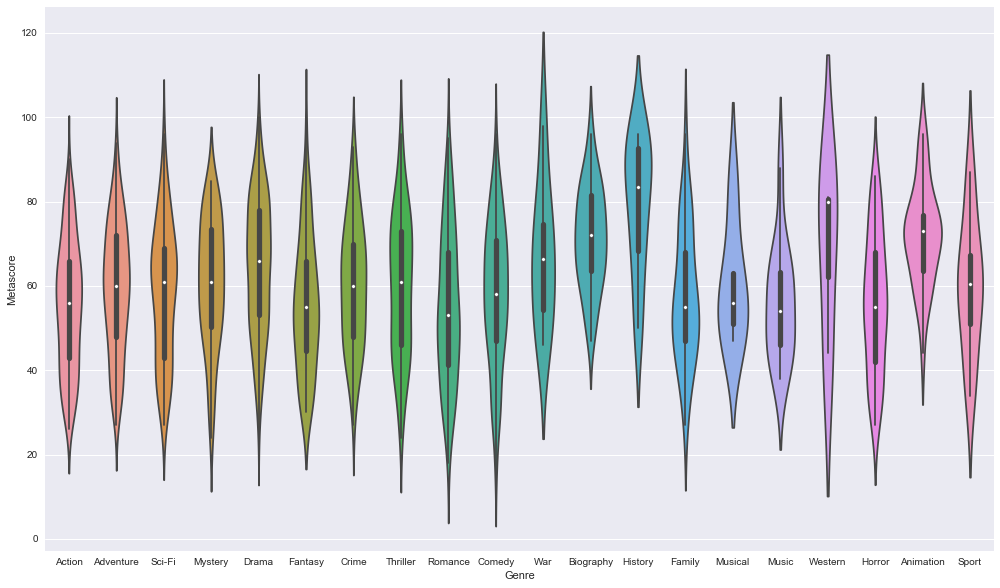

In [12]:
a4_dims = (17, 10)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.violinplot(x="Genre", y="Metascore", data=data3)
sns.plt.show()

### III. Number of Nominations in different genre

Get the number of nominations in each Genre: 
1. use a dictionary dict_genre to store the number of nominations for each genre.
2. print the dictionary

In [13]:
dict_genre = {}
#find the number of keys(genres)
for i, rowi in data3.iterrows():
    dict_genre[rowi['Genre']] = 0
    
#counting
for i, rowi in data3.iterrows():
    if rowi['Nomination'] != 0:
        dict_genre[rowi['Genre']] = dict_genre[rowi['Genre']] + 1
        
dict_genre

{'Action': 1,
 'Adventure': 6,
 'Animation': 0,
 'Biography': 17,
 'Comedy': 6,
 'Crime': 5,
 'Drama': 45,
 'Family': 0,
 'Fantasy': 1,
 'History': 5,
 'Horror': 0,
 'Music': 0,
 'Musical': 1,
 'Mystery': 5,
 'Romance': 9,
 'Sci-Fi': 2,
 'Sport': 2,
 'Thriller': 9,
 'War': 0,
 'Western': 1}

Draw a graph that shows the number of nominations in each genre.
Conclusion: drama has highest number of nominations, much higher than the rest of the genres. 

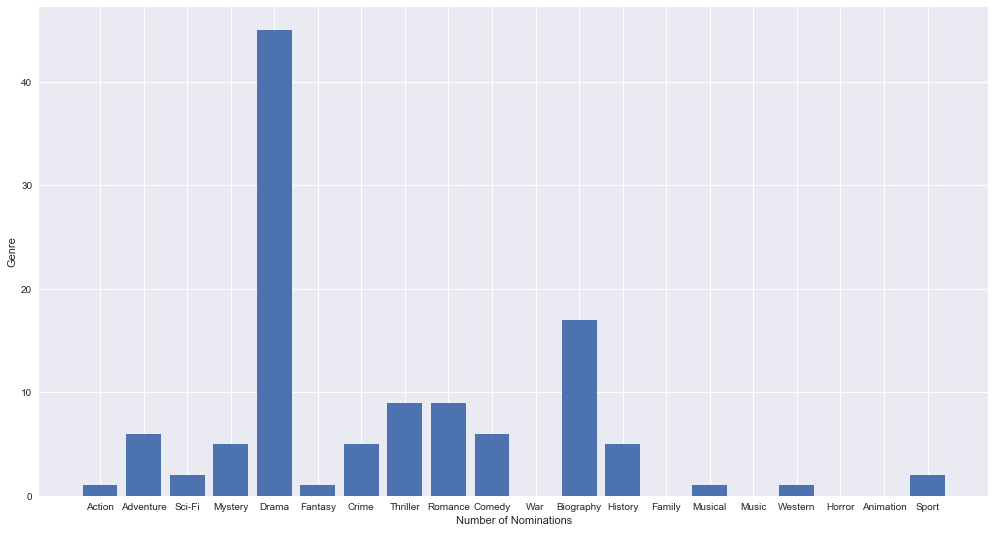

In [14]:
fig = plt.gcf()
plt.bar(range(len(dict_genre)), list(dict_genre.values()), align='center')
plt.xticks(range(len(dict_genre)), list(dict_genre.keys()))
plt.xlabel('Number of Nominations')
plt.ylabel('Genre')
fig.set_size_inches(17, 9)
plt.show()

### IV. Relation between Rating and Standardized_Revenue

Aim: find the relation between nomination and revenue, x is 'standardized_revenue' which is computed by (Revenue - average revenue of this year) / sqrt(std of this year's revenue) 
1. initialize two dictionaries dict_ave and dict_std to calculate each year's mean and std.
2. iterate through the data table and calculate the standardized_revenue for each row
3. draw scatter plot
4. add a regression line to the plot

In [15]:
#calculate the (Revenue - average of this year) / sqrt(std of this year) 
dict_ave = {}
dict_std = {}

for i in range(2006, 2016):
    data_cur = data[data.Year == i]
    dict_ave[i] = data_cur['Revenue'].mean()
    dict_std[i] = data_cur['Revenue'].std()
    
#add the 'standardized_revenue', 'Average' and 'std' column
data['standardized_revenue'] = 0
data['Average'] = 0
data['Std'] = 0


In [16]:
#calculate the standardized_revenue for each row
for i, rowi in data.iterrows():
    year = int(rowi['Year'])
    value = (rowi['Revenue'] - dict_ave[year]) / math.sqrt(dict_std[year])
    data.set_value(i, 'standardized_revenue', value)
    data.set_value(i, 'Std', dict_std[year])
    data.set_value(i, 'Average', dict_ave[year])
data.head()

,Title,Genre,Year,Rating,Votes,Revenue,Metascore,Nomination,standardized_revenue,Average,Std
0,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",2014,8.1,757074,333.13,76.0,0,26,85,86
1,Prometheus,"Adventure,Mystery,Sci-Fi",2012,7.0,485820,126.46,65.0,0,1,110,117
3,Interstellar,"Adventure,Drama,Sci-Fi",2014,8.6,1047747,187.99,74.0,0,11,85,86
5,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",2011,6.7,395025,241.06,45.0,0,15,93,86
6,Star Wars: Episode VII - The Force Awakens,"Action,Adventure,Fantasy",2015,8.1,661608,936.63,81.0,0,74,80,132


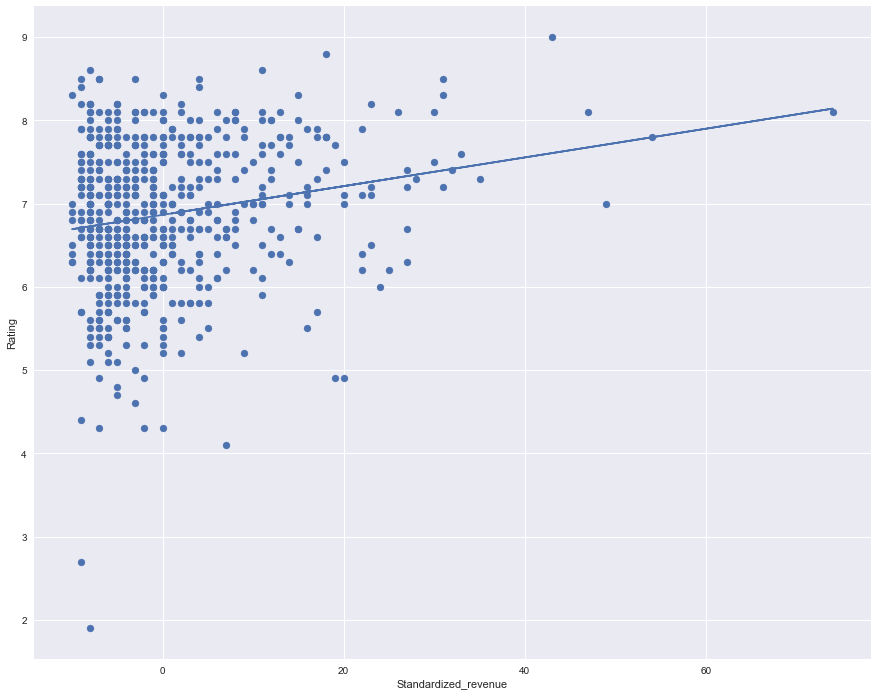

In [17]:
#draw the scatter plot
fig = plt.gcf()
plt.scatter(x = data['standardized_revenue'], y = data['Rating'])

#add a regression line
arry1 = np.array(data['standardized_revenue'])
arry2 = np.array(data['Rating'])
m, b = np.polyfit(arry1, arry2, 1)
plt.plot(arry1, m*arry1 + b, '-') 

plt.xlabel('Standardized_revenue')
plt.ylabel('Rating')

#reset figure size
fig.set_size_inches(15, 12)
plt.show()

## 4. Analysis by Machine Learning

Adding new columns to build linear regression model later.

In order to find more information about the relationship between the chance of getting nominated and rating, metascore, votes and revenue, we find their average. <br>
Here are the average rating and metascore over all data. <br>
Because rating and metascore are given by regular audience and professional reviewers. The amount of people review might be influenced by each year's economy, but the average score won't be affected. Therefore we are calculated them as a whole.

In [18]:
average_rating_all_time = data["Rating"].mean()
average_matascore_all_time = data["Metascore"].mean()

Get every year's average revenue, the reason we are calculating this by year is unlike rating, each year's economy might affect the box office. So it's more objective this way. Same thing happen to votes, because economy also affects the money people spending on movie tickets or dvd. Which affect the number of audience and number of votes.

We stroe these information in hashmap with year as key and data in a year as value.

In [19]:
average_revenue_by_years = data.groupby("Year")
average_reveneue_map = {}
for name, group in average_revenue_by_years:
    average_reveneue_map[name] = group["Revenue"].mean()

In [20]:
average_votes_by_years = data.groupby("Year")
average_votes_map = {}
for name, group in average_votes_by_years:
    average_votes_map[name] = group["Votes"].mean()

In [21]:
average_rating_all_time

6.866874999999991

In [22]:
average_matascore_all_time

59.696875

In [23]:
average_votes_map

{2006: 277232.2195121951,
 2007: 266530.70454545453,
 2008: 266580.1458333333,
 2009: 267180.5777777778,
 2010: 261082.9298245614,
 2011: 259254.73684210525,
 2012: 290861.48387096776,
 2013: 225531.89285714287,
 2014: 211926.8817204301,
 2015: 129512.6513761468}

In [24]:
average_reveneue_map

{2006: 87.25560975609757,
 2007: 93.0740909090909,
 2008: 97.52541666666669,
 2009: 115.742,
 2010: 105.08157894736843,
 2011: 93.70333333333335,
 2012: 110.10306451612907,
 2013: 88.08464285714282,
 2014: 85.43365591397847,
 2015: 80.72559633027525}

Create 4 additional column <br>
rating_vs_aveRating is current rating / average rating <br>
metascore_vs_aveMeta is current metascore / average metascore <br>
revenue_vs_aveRevenue is current revenue / average revenue in current year <br>
votes_vs_aveVotes is current votes / average votes in current year

With these additional column, we can create two linear model, one is nominated vs four factors (rating, metascore, votes, revenue), another is nominated vs ratio of four factors against average of each factors. Then we can determine which model to use.

In [25]:
data["Rating_vs_aveRating"] = 0.0
data["Metascore_vs_aveMeta"] = 0.0
data["Revenue_vs_aveRevenue"] = 0.0
data["Votes_vs_aveVotes"] = 0.0

In [26]:
for index, row in data.iterrows():
    data.set_value(index, "Rating_vs_aveRating", row["Rating"] / average_rating_all_time)
    data.set_value(index, "Metascore_vs_aveMeta", row["Metascore"] / average_matascore_all_time)
    
    current_year = row["Year"]
    
    data.set_value(index, "Revenue_vs_aveRevenue", row["Revenue"] / average_reveneue_map[current_year])
    data.set_value(index, "Votes_vs_aveVotes", row["Votes"] / average_votes_map[current_year])


Here's the new table after adding 4 columns.

In [27]:
data.head()

,Title,Genre,Year,Rating,Votes,Revenue,Metascore,Nomination,standardized_revenue,Average,Std,Rating_vs_aveRating,Metascore_vs_aveMeta,Revenue_vs_aveRevenue,Votes_vs_aveVotes
0,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",2014,8.1,757074,333.13,76.0,0,26,85,86,1.179576,1.273098,3.899283,3.572336
1,Prometheus,"Adventure,Mystery,Sci-Fi",2012,7.0,485820,126.46,65.0,0,1,110,117,1.019387,1.088834,1.148560,1.670280
3,Interstellar,"Adventure,Drama,Sci-Fi",2014,8.6,1047747,187.99,74.0,0,11,85,86,1.252389,1.239596,2.200421,4.943908
5,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",2011,6.7,395025,241.06,45.0,0,15,93,86,0.975699,0.753808,2.572587,1.523694
6,Star Wars: Episode VII - The Force Awakens,"Action,Adventure,Fantasy",2015,8.1,661608,936.63,81.0,0,74,80,132,1.179576,1.356855,11.602640,5.108443


Now we seperate data into two sets. <br>
First set contains data from 2006 to 2013 used as training data. <br>
Second set contains data from 2014 to 2015 used as testing data. <br>
Amount of training data is about twice the size of testing data.

In [28]:
training_data = data.loc[data["Year"] < 2014]
testing_data = data.loc[data["Year"] > 2013]

Make a linear regression on nominee vs combination of rating, metascore, revenue, and votes

In [29]:
x_var = ["Rating", "Metascore", "Revenue", "Votes"]
y_var = "Nomination"


X = [list(row.values) for _, row in training_data[x_var].iterrows()]
X_OLS = sm.add_constant(X)
Y = training_data[y_var].values


model1 = sm.OLS(Y, X_OLS)
model1.data.xnames = ['const'] + x_var
model1.data.ynames = "Nomination"
result1 = model1.fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Nomination   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     13.39
Date:                Sat, 16 Dec 2017   Prob (F-statistic):           2.69e-10
Time:                        00:40:48   Log-Likelihood:                -6.3304
No. Observations:                 438   AIC:                             22.66
Df Residuals:                     433   BIC:                             43.07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2502      0.112     -2.237      0.026      -0.470      -0.030
Rating         0.0028      0.021      0.135      0.893      -0.039       0.044
Metascore      0.0051      0.001      5.033      0.000       0.003       0.007
Revenue       -0.0002      0.000     -0.994      0.321      -0.000       0.000
Votes       4.251e-08   9.14e-08      0.465      0.642   -1.37e-07    2.22e-07
==============================================================================
Omnibus:                      259.406   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1368.665
Skew:                           2.724   Prob(JB):                    6.28e-298
Kurtosis:                       9.732   Cond. No.                     3.22e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Make a linear regression on nominee vs combination of rating against average, metascore against average, revenue against average, and votes against average.

In [30]:
x_var = ["Rating_vs_aveRating", "Metascore_vs_aveMeta", "Revenue_vs_aveRevenue", "Votes_vs_aveVotes"]
y_var = "Nomination"


X = [list(row.values) for _, row in training_data[x_var].iterrows()]
X_OLS = sm.add_constant(X)
Y = training_data[y_var].values


model2 = sm.OLS(Y, X_OLS)
model2.data.xnames = ['const'] + x_var
model2.data.ynames = "Nomination"
result2 = model2.fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Nomination   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     13.50
Date:                Sat, 16 Dec 2017   Prob (F-statistic):           2.23e-10
Time:                        00:40:48   Log-Likelihood:                -6.1356
No. Observations:                 438   AIC:                             22.27
Df Residuals:                     433   BIC:                             42.68
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.2310      0.112     -2.070      0.039      -0.450      -0.012
Rating_vs_aveRating      -0.0046      0.144     -0.032      0.975      -0.288       0.279
Metascore_vs_aveMeta      0.3039      0.060      5.031      0.000       0.185       0.423
Revenue_vs_aveRevenue    -0.0185      0.015     -1.202      0.230      -0.049       0.012
Votes_vs_aveVotes         0.0196      0.024      0.815      0.415      -0.028       0.067
==============================================================================
Omnibus:                      259.376   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1371.118
Skew:                           2.722   Prob(JB):                    1.84e-298
Kurtosis:                       9.744   Cond. No.                         37.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Comparing two regression model, we can tell the first one makes more sense, when we look at the coefficient, consider higher rating and higher metascore increase the chance a film gets nominated. And higher revenue decrease chance of getting nominated because usually commerical movies are not welcomed by the award association. We also discovered votes play small parts of the prediction since usually artistic movies are not super popular.

## 5. Summary 

## 6. Resources and Reference
This tutorial highlighted several methods of data curation, analysis, and visualization. More information about the libraries or packages we have used in our Oscar Analysis are available from the following links:

Pandas: http://pandas.pydata.org/

PyPlot: https://matplotlib.org/api/pyplot_api.html

Basemap: https://matplotlib.org/basemap/

Scikit Image: http://scikit-image.org/

Scikit Learn: https://pypi.python.org/pypi/scikit-learn/0.18.1

Dataset1: https://www.kaggle.com/sebask/the-oscars-dataset-preparing-for-2017/data

Dataset2: https://www.kaggle.com/sebask/the-oscars-dataset-preparing-for-2017/data